In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import os
import sys



import PIL
from PIL import Image 


import requests


import torch
import torch.nn as nn
import torch.nn.functional as F


import torch.utils.data as data_utils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms


print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
__pyTorch VERSION: 1.7.0+cu101
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
__CUDNN VERSION: 7603
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/LB_CNN_Models/GibbsSampler_LB_CNN.py GibbsSampler_LB_CNN.py
!cp /content/drive/MyDrive/ColabNotebooks/LB-CNN/DenseNet/torchvision_DenseNet.py torchvision_DenseNet.py

from torchvision_DenseNet import DenseNet
from torchvision_DenseNet import _DenseLayer
from torchvision_DenseNet import _DenseBlock
from torchvision_DenseNet import _Transition
from torchvision_DenseNet import _load_state_dict
from torchvision_DenseNet import _densenet
from torchvision_DenseNet import densenet201
from GibbsSampler_LB_CNN import LB_CNN_Gibbs

In [4]:
def build_NamesDict(namesDict_location):
    names = pd.read_csv(namesDict_location) #Read CSV for dictionary
    names = dict(zip(names['Keys'].values,names['Values'].values))
    inv_names = {v: k for k, v in names.items()} #Invert Relation
    return names, inv_names

In [5]:
transforms_test = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

In [6]:
ImageNet_Dict_loc = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/ImageNetInfo/Imagenet_dict'

In [7]:
names, inv_names =  build_NamesDict(ImageNet_Dict_loc)

In [8]:
dense_net = densenet201(pretrained=False)
model_loc = '/content/drive/MyDrive/ColabNotebooks/LB-CNN/Models/ImageNet/'
dense_net_dict = torch.load(model_loc  + "DenseNet_M16.mdl")
dense_net.load_state_dict(dense_net_dict['state_dict'])

<All keys matched successfully>

In [9]:
for i, param in enumerate(dense_net.parameters()):        
    param.requires_grad = False
    print("Freezing Parameter: {}-{}".format(i,param.shape))

Freezing Parameter: 0-torch.Size([64, 3, 7, 7])
Freezing Parameter: 1-torch.Size([64])
Freezing Parameter: 2-torch.Size([64])
Freezing Parameter: 3-torch.Size([64])
Freezing Parameter: 4-torch.Size([64])
Freezing Parameter: 5-torch.Size([128, 64, 1, 1])
Freezing Parameter: 6-torch.Size([128])
Freezing Parameter: 7-torch.Size([128])
Freezing Parameter: 8-torch.Size([32, 128, 3, 3])
Freezing Parameter: 9-torch.Size([96])
Freezing Parameter: 10-torch.Size([96])
Freezing Parameter: 11-torch.Size([128, 96, 1, 1])
Freezing Parameter: 12-torch.Size([128])
Freezing Parameter: 13-torch.Size([128])
Freezing Parameter: 14-torch.Size([32, 128, 3, 3])
Freezing Parameter: 15-torch.Size([128])
Freezing Parameter: 16-torch.Size([128])
Freezing Parameter: 17-torch.Size([128, 128, 1, 1])
Freezing Parameter: 18-torch.Size([128])
Freezing Parameter: 19-torch.Size([128])
Freezing Parameter: 20-torch.Size([32, 128, 3, 3])
Freezing Parameter: 21-torch.Size([160])
Freezing Parameter: 22-torch.Size([160])
Free

In [10]:
M = 16
num_features = 1920 #From DenseNet
num_samples = 100
K = 1000
net = LB_CNN_Gibbs(num_features = num_features,num_classes = K,latent_size = M,num_samples = num_samples,sample_Type = 3,debug_mode = False)
alpha_0 = pd.read_csv(model_loc  + '/alpha_0_M{}.csv'.format(M),header = None).values.squeeze()
alpha = pd.read_csv(model_loc  + '/alpha_M{}.csv'.format(M),header = None).values.squeeze()
beta_0 = pd.read_csv(model_loc  + '/beta_0_M{}.csv'.format(M),header = None).values.squeeze()
beta = pd.read_csv(model_loc  + '/beta_M{}.csv'.format(M),header = None).values.squeeze()

net.alpha_0_tensor.data = torch.tensor(alpha_0)
net.alpha_tensor.data = torch.tensor(alpha)
net.beta_0_tensor.data = torch.tensor(beta_0)
net.beta_tensor.data = torch.tensor(beta)

In [11]:
net = net.type(torch.DoubleTensor).to(device)
dense_net = dense_net.type(torch.DoubleTensor).to(device)
net.eval()
dense_net.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [67]:
#img_loc = 'https://thehappypuppysite.com/wp-content/uploads/2018/07/black-pomeranian-MK-long.jpg' #Change picture location for a different example
#img_loc = 'https://www.yourpurebredpuppy.com/dogbreeds/photos-IJKL/japanesechinf1.jpg'
img_loc = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/26155623/Siberian-Husky-standing-outdoors-in-the-winter.jpg'
im = Image.open(requests.get(img_loc, stream=True).raw)

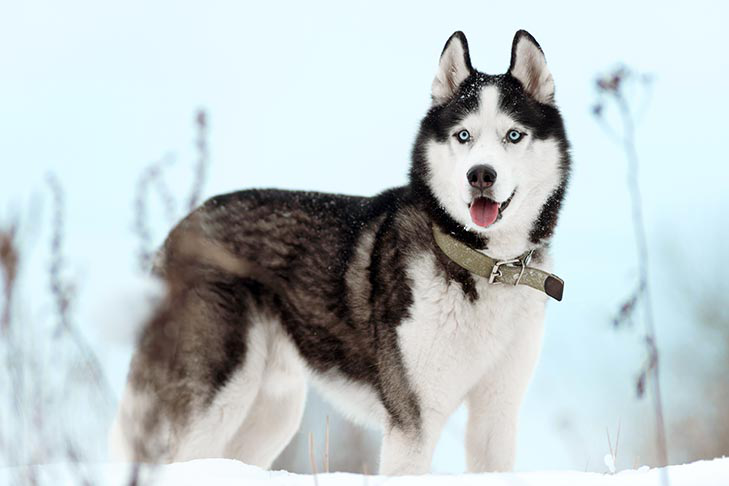

In [68]:
im

In [69]:
x = transforms_test(im).unsqueeze(dim = 0)

In [70]:
out, _ =dense_net(x.type(torch.DoubleTensor).to(device))

In [94]:
Z,EZ,Y_pred,Y_predEZ = net.predict_Y(out)

In [72]:
Z = Z.cpu().numpy()
EZ = EZ.cpu().numpy()
Y_pred = Y_pred.cpu().numpy()
Y_predEZ = Y_predEZ.cpu().numpy()

In [73]:
print('Predicted Codeword:\n{}'.format(Z))
print('Expected Value of Codeword:\n{}'.format(EZ))

Predicted Codeword:
[[-1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1.  1.]]
Expected Value of Codeword:
[[-1.          1.          0.99999895 -1.          1.          0.99999999
   1.         -1.          1.         -1.         -1.          1.
   1.          1.         -1.          1.        ]]


In [74]:
print('Predicted Class: {} -->{}'.format(Y_pred[0],names[Y_pred[0]]))

Predicted Class: 250 -->Siberian husky


In [75]:
print('Predicted Class: {} -->{}'.format(Y_predEZ[0],names[Y_predEZ[0]]))

Predicted Class: 250 -->Siberian husky


# Determine Codebook

In [76]:
import itertools

In [77]:
def binaryValues(k):
    bins = list(itertools.product([0, 1], repeat=k))
    bins = np.array(bins).reshape(-1,k).astype(dtype = np.double)
    return bins

In [78]:
code_space = (2*binaryValues(M)-1).astype(dtype = np.int32) #All possible codes

In [79]:
# Compute probability across entire codespace
linear = beta_0[:,None] + np.matmul(beta,code_space.T)
probs = np.exp(linear)/np.sum(np.exp(linear),axis = 0)

In [80]:
probs.shape

(1000, 65536)

In [81]:
top_ind = [] #Obtain top10 codewords for each class
for k in range(1000):
    top_ind.append(np.argsort(probs[k,:])[-10:][::-1])

In [82]:
top1 = [ind[0] for ind in top_ind]
code_book = [code_space[k].tolist() for k in top1]
code_book = np.asarray(code_book)

In [83]:
print('{} Codeword: \n{}'.format(names[Y_pred[0]],code_book[Y_pred[0],:]))
print('Predicted Codeword:\n{}'.format(Z.astype(np.int32).squeeze()))
print('Prediction Probability: {:.2f}%'.format(100*probs[Y_pred[0],top_ind[Y_pred[0]][0]]))

Siberian husky Codeword: 
[ 1  1  1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1  1]
Predicted Codeword:
[-1  1  1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1  1]
Prediction Probability: 50.90%


In [84]:
#Predict Top5
distance_idx = np.argsort([np.sum(np.abs(v-code_book[Y_pred[0]])) for v in code_book])
for i, idx in enumerate(distance_idx[0:5]):
  print('Top{}-->{}-->{}'.format(i+1,idx,names[idx]))

Top1-->250-->Siberian husky
Top2-->255-->Leonberg
Top3-->248-->Eskimo dog, husky
Top4-->469-->caldron, cauldron
Top5-->235-->German shepherd, German shepherd dog, German police dog, alsatian


# Explore Dog Codes

In [85]:
dog_ids = np.asarray([151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
       268])

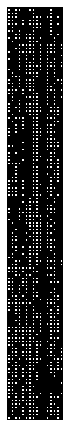

In [86]:
colors = ['black', 'white']
num_colors = 2
plt.figure(figsize = (1,10))
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)
ax = sns.heatmap(code_book[dog_ids,:],cmap=cmap,
                 xticklabels = False, yticklabels = False, linecolor = 'black',linewidths = 1,
                 annot = False,square=True, cbar=False)
ax.set_ylim(len(dog_ids), -0.5)
plt.show()

In [87]:
toy_dogs = np.asarray([151, 152, 153, 154, 155, 156, 157, 158,259])
toy_dog_names = np.asarray([names[idx] for idx in toy_dogs]) #Included Pomeranian

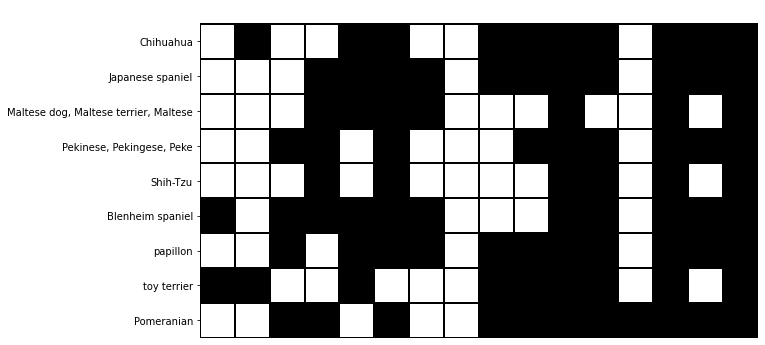

In [88]:
colors = ['black', 'white']
num_colors = 2
plt.figure(figsize = (10,15))
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)
ax = sns.heatmap(code_book[toy_dogs,:],cmap=cmap,
                 xticklabels = False, yticklabels = toy_dog_names, linecolor = 'black',linewidths = 1,
                 annot = False,square=True, cbar=False)
ax.set_ylim(len(toy_dogs), -0.5)
plt.show()

In [89]:
#Test Chihuahua code to double check
test_prob = np.exp(beta_0 + np.matmul(np.array([1,-1,1,1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1]),beta.T))/np.sum(np.exp(beta_0 + np.matmul(np.array([1,-1,1,1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1]),beta.T)))

In [90]:
names[np.argmax(test_prob)]

'Chihuahua'

In [107]:
test_code = code_book[248,:]
np.prod(np.exp(np.multiply(test_code ,alpha_0+np.dot(out.cpu().numpy(),alpha.T)))/(1+np.exp(np.multiply(test_code ,alpha_0+np.dot(out.cpu().numpy(),alpha.T)))))

2.826905766762967e-12

In [113]:
np.exp(np.sum(np.log(np.exp(np.multiply(test_code ,alpha_0+np.dot(out.cpu().numpy(),alpha.T)))/(1+np.exp(np.multiply(test_code ,alpha_0+np.dot(out.cpu().numpy(),alpha.T)))))))

2.8269057667629594e-12